# PyCOCO を使用したデータセットの作成

COCOデータセットについては，以下のサイトを参照．

REF: [COCO Common Objects in Context](https://cocodataset.org/#download)

作成方法は以下のサイトを参考．

REF: [セマンティック画像セグメンテーションのためのCOCOデータセットをマスターする1](https://ichi.pro/semanthikku-gazo-segumente-shon-no-tame-no-coco-de-tasetto-o-masuta-suru-126611649400903)

In [12]:
from typing import List, Literal, Union
from pycocotools.coco import COCO
import numpy as np
# import skimage.io as io
import random
import os
import cv2
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

### For visualizing the outputs ###
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [13]:
data_root = '../data/COCOdataset2017/'
split = 'train'
annFile = "{}/{}/annotations/instances_{}2017.json".format(data_root, split, split)

In [14]:
# Initialize the COCO api for instance annotations
coco = COCO(annFile)

loading annotations into memory...
Done (t=18.57s)
creating index...
index created!


In [15]:
# Load the categories in a variable
catIDs = coco.getCatIds()
cats = coco.loadCats(catIDs)

print(catIDs)
print(cats)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 70, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90]
[{'supercategory': 'person', 'id': 1, 'name': 'person'}, {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'}, {'supercategory': 'vehicle', 'id': 3, 'name': 'car'}, {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'}, {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'}, {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'}, {'supercategory': 'vehicle', 'id': 7, 'name': 'train'}, {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'}, {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'}, {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'}, {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'}, {'supercategory': 'outdoor', 'id': 13, 'name': 's

In [16]:
def getClassName(classID: int, cats: dict):
    for i in range(len(cats)):
        if cats[i]['id'] == classID:
            return cats[i]["name"]
    return "None"

print('The class name is', getClassName(77, cats))

The class name is cell phone


# 指定されたクラスの全画像を読みだす

In [17]:
# 81個のクラスのうち、表示したいクラスを指定してください。それ以外のクラスは表示されません。
filterClasses = ['laptop', 'tv', 'cell phone']

# filterClassesに対応するクラスIDのみを取得する
catIds = coco.getCatIds(catNms=filterClasses)
# 上記のカテゴリーIDを含むすべての画像を取得する
imgIds = coco.getImgIds(catIds=catIds)
print("Number of images containing all the  classes:", len(imgIds))

Number of images containing all the  classes: 238


In [18]:
# load and display a random image
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
# img_fp = Path('{}/images/{}/{}'.format(dataDir,dataType,img['file_name'])).resolve()
# I = cv2.imread('{}/images/{}/{}'.format(dataDir,dataType,img['file_name']))
I = cv2.imread('{}/{}/{}'.format(dataDir,dataType,img['file_name']))
# I = cv2.imread(img_fp)

if I is not None:
    plt.axis('off')
    plt.imshow(I)
    plt.show()

TypeError: Image data of dtype object cannot be converted to float

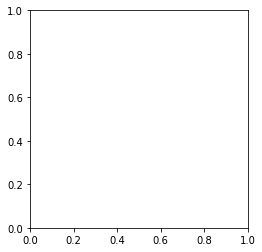

In [19]:
plt.imshow(I)
plt.axis('off')
annIds = coco.getAnnIds(imgIds=img['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)
coco.showAnns(anns)

# GENERATE A SEGMENTATION MASK
任意のセグメンテーションモデルのトレーニングに使用できるデータジェネレーターを作成する．
作成方法は以下のサイトを参照．

web site: [セマンティック画像セグメンテーションのためのCOCOデータセットをマスターする ](https://ichi.pro/semanthikku-gazo-segumente-shon-no-tame-no-coco-de-tasetto-o-masuta-suru-212008000751978)

GitHub: [
COCO Data Generator for Semantic Segmentation](https://github.com/virafpatrawala/COCO-Semantic-Segmentation/blob/master/COCOdataset_SemanticSegmentation_Demo.ipynb)

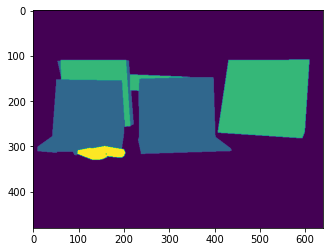

In [ ]:
filterClasses = ['laptop', 'tv', 'cell phone']
mask = np.zeros((img['height'],img['width']))
for i in range(len(anns)):
    className = getClassName(anns[i]['category_id'], cats)
    pixel_value = filterClasses.index(className)+1
    mask = np.maximum(coco.annToMask(anns[i])*pixel_value, mask)
plt.imshow(mask)

In [ ]:
def FilterDataset(root_dir, classes: Union[List[str], None] = None, mode: Literal['train', 'val', 'test'] ='train'):
    """フィルタしたクラスのオブジェクトが映る画像をすべて読みだす関数

    Args:
        root_dir (str): データセットの root ディレクトリ．
        classes (Union(List[str], None), optional): 抽出するクラス名のリスト. Defaults to None.
        mode (str, optional): 読みだすデータセットの種類（'train' or 'val', or 'test'）. Defaults to 'train'.

    Returns:
        [type]: [description]
    """
    # initialize COCO api for instance annotations
    annFile = '{}/annotations/instances_{}2017.json'.format(root_dir, mode)
    coco = COCO(annFile)

    images = []
    if classes != None:
        # リスト内の個々のクラスに対してイテレートする
        for className in classes:
            # 与えられたカテゴリを含むすべての画像を取得する
            catIds = coco.getCatIds(catNms=className)
            imgIds = coco.getImgIds(catIds=catIds)
            images += coco.loadImgs(imgIds)

    else:
        imgIds = coco.getImgIds()
        images = coco.loadImgs(imgIds)

    # Now, filter out the repeated images
    unique_images = []
    for i in range(len(images)):
        if images[i] not in unique_images:
            unique_images.append(images[i])
            
    random.shuffle(unique_images)
    dataset_size = len(unique_images)
    
    return unique_images, dataset_size, coco


In [ ]:
dataDir = '../../data/COCOdataset2017/'
classes = ['laptop', 'tv', 'cell phone']
mode = 'train'

imgs, dataset_size, coco = FilterDataset(dataDir, classes=classes, mode=mode)

loading annotations into memory...
Done (t=18.78s)
creating index...
index created!


In [ ]:
def getImage(imgObj, img_folder: str, input_img_size: tuple):
    # Read and normalize an image
    train_img = cv2.imread(os.path.join(img_folder, imgObj['file_name'])) / 255.0
    # Resize
    train_img = cv2.resize(train_img, input_img_size)
    if (len(train_img.shape) == 3 and train_img.shape[2]==3): # If it is a RGB 3 channel image
        return train_img
    else: # 白黒の画像を扱う場合は、次元を3にする
        stacked_img = np.stack((train_img,)*3, axis=-1)
        return stacked_img

In [ ]:
def getNormalMask(imgObj, classes, coco, catIds, input_img_size):
    annIds = coco.getAnnIds(imgObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds)
    cats = coco.loadCats(catIds)
    train_mask = np.zeros(input_img_size)
    for a in range(len(anns)):
        className = getClassName(anns[a]['category_id'], cats)
        pixel_value = classes.index(className)+1
        new_mask = cv2.resize(coco.annToMask(anns[a])*pixel_value, input_img_size)
        train_mask = np.maximum(new_mask, train_mask)

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_img_size[0], input_img_size[1], 1)
    return train_mask

In [ ]:
def getBinaryMask(imgObj, coco, catIds, input_img_size):
    annIds = coco.getAnnIds(imgObj['id'], catIds=catIds, iscrowd=None)
    anns = coco.loadAnns(annIds) # アノテーションを読みだす
    # train_mask = np.zeros(input_img_size)
    for a in range(len(anns)):
        new_mask = cv2.resize(coco.annToMask(anns[a]), input_img_size)
        
        #Threshold because resizing may cause extraneous values
        new_mask[new_mask >= 0.5] = 1
        new_mask[new_mask < 0.5] = 0

        # 画素の位置ごとの最大値を返す
        train_mask = np.maximum(new_mask, train_mask)
        if a == 0:
            train_mask = mask
        else:
            train_mask = np.stack(train_mask, mask, axis=3).astype('float')

    # Add extra dimension for parity with train_img size [X * X * 3]
    train_mask = train_mask.reshape(input_img_size[0], input_img_size[1], 1)
    return train_mask

In [ ]:
def dataGeneratorCoco(imgs, classes, coco, root_dir: str, input_img_size: tuple=(224, 224), batch_size = 4, mode: Literal['train', 'val', 'test'] ='train', mask_type: Literal['binary', "normal"]='binary'):
    img_folder = '{}/{}'.format(root_dir, mode)
    dataset_size = len(imgs)
    catIds = coco.getCatIds(catNms = classes)

    c = 0
    while(True):
        img = np.zeros((batch_size, input_img_size[0], input_img_size[1], 3)).astype('float')
        mask = np.zeros((batch_size, input_img_size[0], input_img_size[1], 1)).astype('float')

        for i in range(c, c+batch_size):
            imgObj = imgs[i]
            
            ### Retrieve Image ###
            train_img = getImage(imgObj=imgObj, img_folder=img_folder, input_img_size=input_img_size)

            ### Create Mask ###
            if mask_type=="binary":
                train_mask = getBinaryMask(imgObj, coco, catIds, input_img_size)
            
            elif mask_type=="normal":
                train_mask = getNormalMask(imgObj, classes, coco, catIds, input_img_size)                
            
            # Add to respective batch sized arrays
            img[i-c] = train_img
            mask[i-c] = train_mask
            
        c+=batch_size
        if(c + batch_size >= dataset_size):
            c=0
            random.shuffle(imgs)
        yield img, mask

In [ ]:
batch_size = 4
input_img_size = (224,224)
mask_type = 'binary'

train_gen = dataGeneratorCoco(imgs, classes, coco, dataDir, input_img_size, batch_size, mode, mask_type)

In [ ]:
def visualizeGenerator(gen):
    # Iterate the generator to get image and mask batches
    img, mask = next(gen)

    fig = plt.figure(figsize=(20, 10))
    outerGrid = gridspec.GridSpec(1, 2, wspace=0.1, hspace=0.1)
    
    for i in range(2):        
        innerGrid = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outerGrid[i], wspace=0.05, hspace=0.05)

        for j in range(4):
            ax = plt.Subplot(fig, innerGrid[j])
            if(i==1):
                ax.imshow(img[j]);
            else:
                ax.imshow(mask[j][:,:,0]);
                
            ax.axis('off')
            fig.add_subplot(ax)
    plt.show()

In [ ]:
visualizeGenerator(train_gen)

TypeError: _stack_dispatcher() got multiple values for argument 'axis'

In [ ]:
import segmentation_models_pytorch as smp

ENCODER = "efficientnet-b0"
ENCODER_WEIGHTS = "imagenet"
CLASSES = ['laptop', 'tv', 'cell phone']
ACTIVATION = "softmax2d"
DEVICE = 'cuda'

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation

In [ ]:
# create segmentation model with pretrained encoder
model = smp.UnetPlusPlus(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=n_classes, #len(CLASSES), 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)